In [ ]:
import torch
from torch import pi
from matplotlib import pyplot as plt

**Heat equation:**

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

- Boundary Conditions (for all $t \geq 0$.): 
    - $u(0, t) = 0$
    - $u(1, t) = 0$
- Initial Condition:
    - $u(x, 0) = \sin(\pi x)$ for $0 \leq x \leq 1$.

**Analytical solution:**

$u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)$

In [ ]:
def u(x, t, alpha):
    return torch.exp(-alpha*(pi**2)*t)*torch.sin(pi*x)

def du_dt(x, t, alpha):
    return -(alpha*pi**2)*torch.exp(-alpha*t*pi**2)*torch.sin(pi*x)

def d2u_dx2(x, t, alpha):
    return -(pi**2)*torch.exp(-alpha*t*pi**2)*torch.sin(pi*x)

In [ ]:
n_x = 100
n_t = 100
max_t = 100
alpha = 4*1e-8

features, t = torch.linspace(start=0, end=1, steps=n_x), torch.linspace(start=0, end=max_t, steps=n_t)
xx, tt = torch.meshgrid(features, t)
y = u(xx, tt, alpha)

dataset = torch.utils.data.TensorDataset(
    # torch.vstack((xx.flatten(),tt.flatten())).T.requires_grad_(),
    xx.flatten().requires_grad_(),
    tt.flatten().requires_grad_(),
    y.flatten().unsqueeze(1)
    )

/home/andre/anaconda3/envs/hc-dev/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32,1)
)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
constraints = [
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda x, _: torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T), torch.sin(torch.pi*x).unsqueeze(1))
]

constraint_multipliers = torch.tensor([0.1, 0.1, 0.1])

In [ ]:
import numpy as np


epochs = 30
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x, t, y in loader:
        y_hat = model(
            torch.vstack((x, t)).T
        )

        cs = []
        regularization = 0

        for j, constraint in enumerate(constraints):
            c = constraint(x, t)
            cs.append(c.detach().numpy())
            regularization += constraint_multipliers[j] * c
        c_log.append(np.array(cs))

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(),
            inputs=x,
            create_graph=True,
            materialize_grads=True)[0]

        loss_d = mse_loss(jac_t, alpha*hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred + regularization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log)/len(loss_log))
    epoch_loss_log.append(sum(loss_log)/len(loss_log))
    print(sum(c_log)/len(c_log))
    epoch_c_log.append(sum(c_log)/len(c_log))

0.18325791
[0.27720946 0.2765271  0.1112545 ]
0.17373143
[0.2762911  0.2756955  0.09702379]
0.17350511
[0.277484   0.27635393 0.09474873]
0.1696863
[0.27252385 0.27432042 0.08058611]
0.14905702
[0.21696909 0.25678656 0.02320854]
0.13421874
[0.16972902 0.20703733 0.01183108]
0.07212486
[0.08364954 0.14679955 0.01234293]
0.007097315
[0.00205689 0.01218358 0.00847762]
0.00470239
[0.00201161 0.00803183 0.00427999]
0.0054870704
[0.00266137 0.0075036  0.00363335]
0.0013079186
[0.00067596 0.00213289 0.00276066]
0.0006010679
[0.0005009  0.00072753 0.00156622]
0.00057261676
[0.00038727 0.00054077 0.00074448]
0.00092819444
[0.00050736 0.00091043 0.00038602]
0.0006427222
[0.00035108 0.00064699 0.00021221]
0.0010914307
[0.00056565 0.00115407 0.00011213]
0.0014314442
[7.5324124e-04 1.6116494e-03 8.2781618e-05]
0.00024060605
[1.3184264e-04 2.2069665e-04 4.8436472e-05]
0.0011218286
[5.1618437e-04 1.1292903e-03 4.0791583e-05]
0.0002919213
[1.8532784e-04 2.5411154e-04 3.6619844e-05]
0.0005357917
[2.833

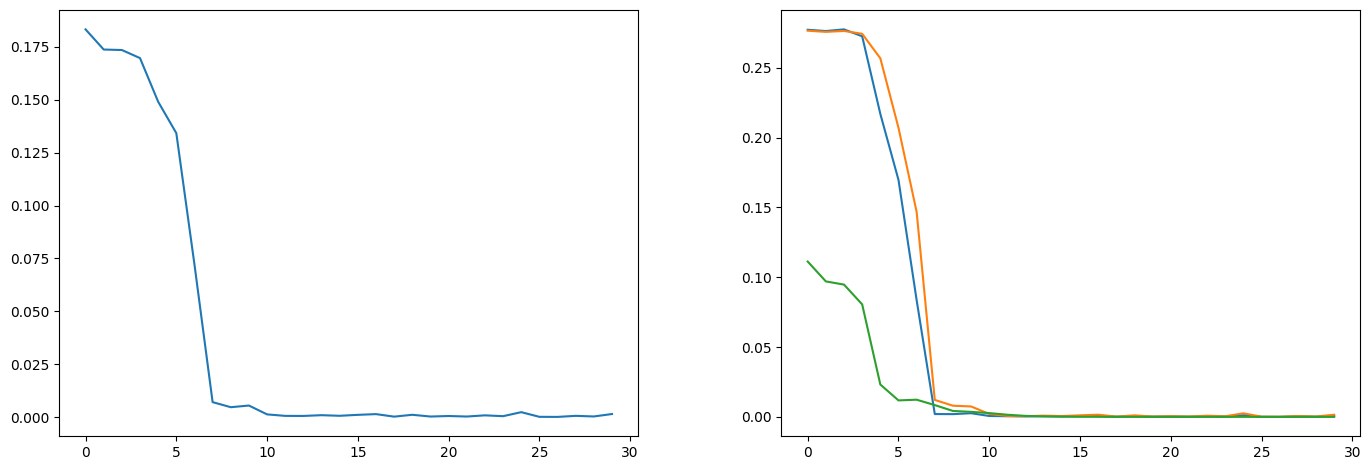

In [ ]:
f = plt.figure()
ax = f.subplots(1,2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

Overall MSE
tensor(0.0001)
MSE on jacobian-hessian relation
tensor(5.8935e-06)
MSE on x=0
tensor(1.2599e-06)
MSE on x=1
tensor(2.5982e-05)
MSE on t=0
tensor(9.4687e-05)


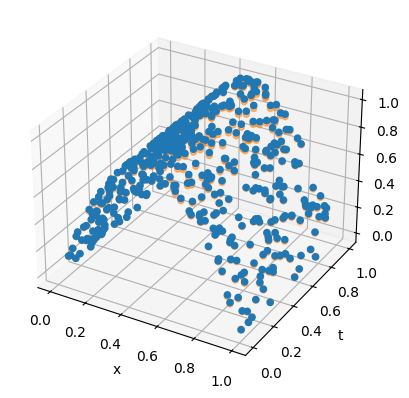

In [ ]:
# %matplotlib ipympl


torch.manual_seed(0)
x = torch.rand(500).requires_grad_()
t = torch.rand(500).requires_grad_()
preds = model(torch.vstack((x, t)).T).unbind()
jac_t = torch.autograd.grad(
        outputs=preds,
        inputs=t,
        grad_outputs=None,
        create_graph=True,
        materialize_grads=True)[0]
hess_x = torch.autograd.grad(
        outputs=jac_x.unbind(),
        inputs=x,
        create_graph=True,
        materialize_grads=True)[0]
loss_d = torch.nn.functional.mse_loss(jac_t, alpha*hess_x).detach()

with torch.inference_mode():
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print('Overall MSE')
    print(torch.nn.functional.mse_loss(preds, _u))
    print('MSE on jacobian-hessian relation')
    print(loss_d)
    print('MSE on x=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on x=1')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on t=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T).squeeze(), torch.sin(torch.pi*x)))

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds,alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')

***

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
from humancompatible.train.optim import SSLALM, SSLALM_Adam

model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32,1)
)

constraints = [
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda x, _: torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T), torch.sin(torch.pi*x).unsqueeze(1))
]
m = len(constraints)
# slack_vars = torch.zeros(m).requires_grad_()

optimizer = SSLALM_Adam(
    params=model.parameters(),
    m=m,
    mu=0.,
    lr=0.005,
    # dual_lr=0.01,
    dual_lr=0.01,
    rho=1.,
    dual_bound=10,
)

In [ ]:
import numpy as np

epochs = 30
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []

for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x ,t, y in loader:
        y_hat = model(
            torch.vstack((x, t)).T
        )
        
        cs = []
        for j, constraint in enumerate(constraints):
            c = constraint(x, t)# + slack_vars[j]
            c.backward()
            optimizer.dual_step(j, c)
            optimizer.zero_grad()
            
            cs.append((c.detach()).detach().numpy())
        c_log.append(np.array(cs))

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(),
            inputs=x,
            create_graph=True,
            materialize_grads=True)[0]

        loss_d = mse_loss(jac_t, alpha*hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred #+ torch.zeros_like(slack_vars) @ slack_vars
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # optimizer.dual_lr *= 0.97

        # with torch.no_grad():
        #     for j in range(len(slack_vars)):
        #         if slack_vars[j] < 0:
        #             slack_vars[j].zero_()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log)/len(loss_log))
    epoch_loss_log.append(sum(loss_log)/len(loss_log))
    print(sum(c_log)/len(c_log))
    epoch_c_log.append(sum(c_log)/len(c_log))

0.15576828
[0.18903008 0.18905076 0.12686428]
0.14809114
[0.16765966 0.16752294 0.1001927 ]
0.15911192
[0.14900191 0.14803311 0.09604418]
0.1661916
[0.137081   0.13480514 0.08667376]
0.16240892
[0.11421184 0.11916061 0.04058551]
0.12870304
[0.08363155 0.10230488 0.01454005]
0.044005916
[0.02586872 0.04216349 0.01739036]
0.0050693336
[0.00115628 0.00514855 0.00539735]
0.0034106325
[0.00099848 0.00267343 0.00339251]
0.0020174675
[0.00063556 0.00145141 0.00248804]
0.005005602
[0.00209384 0.00400045 0.00189488]
0.0043705204
[0.00167815 0.00348371 0.00170081]
0.0010157324
[0.00022734 0.00050631 0.00123838]
0.0008766774
[0.00029166 0.00037792 0.00083148]
0.0006655624
[0.0002115  0.00021751 0.00058055]
0.0011040759
[0.00037055 0.00056429 0.00044159]
0.0015305628
[0.00050518 0.00096239 0.00032564]
0.0012198989
[0.00039903 0.00071615 0.0002492 ]
0.0016891906
[0.00063591 0.00110752 0.0001928 ]
0.0028931755
[0.00106323 0.00211147 0.00020577]
0.0008704669
[0.00021963 0.00040457 0.00013487]
0.00090

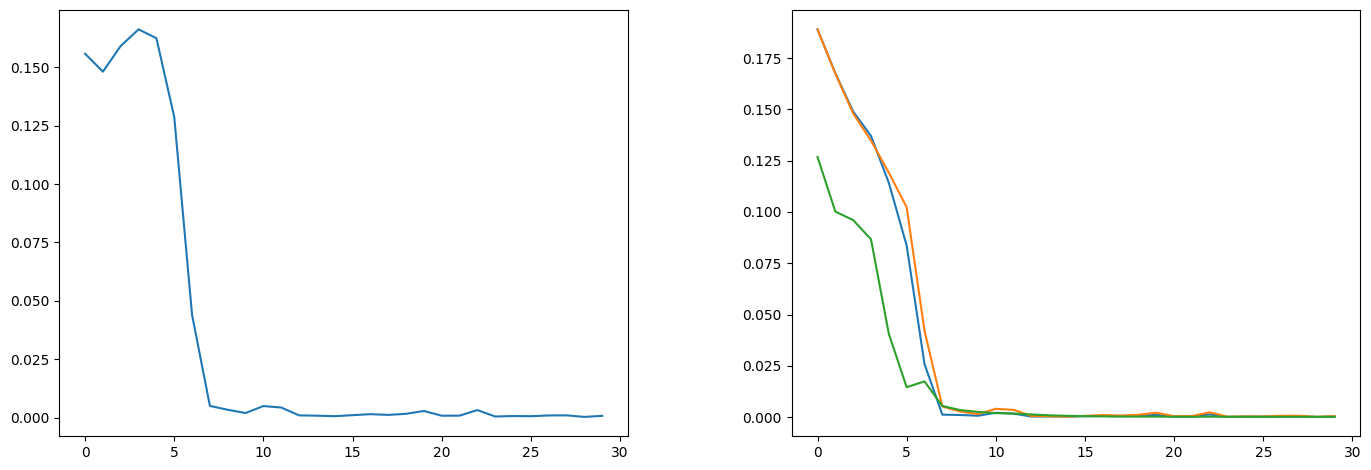

In [ ]:
f = plt.figure()
ax = f.subplots(1,2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

In [ ]:
optimizer._dual_vars

tensor([0.3520, 0.3728, 0.2009])

Overall MSE
tensor(0.0001)
MSE on jacobian-hessian relation
tensor(1.9032e-05)
MSE on x=0
tensor(0.0004)
MSE on x=1
tensor(0.0002)
MSE on t=0
tensor(8.6615e-05)


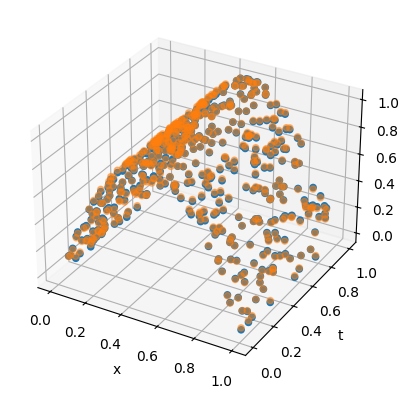

In [ ]:
# %matplotlib ipympl


torch.manual_seed(0)
x = torch.rand(500).requires_grad_()
t = torch.rand(500).requires_grad_()
preds = model(torch.vstack((x, t)).T).unbind()
jac_t = torch.autograd.grad(
        outputs=preds,
        inputs=t,
        grad_outputs=None,
        create_graph=True,
        materialize_grads=True)[0]
hess_x = torch.autograd.grad(
        outputs=jac_x.unbind(),
        inputs=x,
        create_graph=True,
        materialize_grads=True)[0]
loss_d = torch.nn.functional.mse_loss(jac_t, alpha*hess_x).detach()

with torch.inference_mode():
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print('Overall MSE')
    print(torch.nn.functional.mse_loss(preds, _u))
    print('MSE on jacobian-hessian relation')
    print(loss_d)
    print('MSE on x=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on x=1')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on t=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T).squeeze(), torch.sin(torch.pi*x)))

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds,alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')